In [78]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

### Data Loading

In [2]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

lookup_d = {}
seq_list = []
count = 0
for record in SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytplasm"
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Cytoplasm"
        lookup_d[ID] = label

In [3]:
seq_df = pd.DataFrame(seq_list)
seq_df.describe(percentiles=[.91, .95, .99])

,0
count,12704.000000
mean,418.507793
std,234.958061
min,40.000000
50%,389.000000
91%,781.000000
95%,873.000000
99%,988.970000
max,1024.000000


In [4]:
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

In [5]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}


def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

#### Section Below for Embeddings and PCA. Not necessary for modeling

In [ ]:
deeploc_df = train_df.append(valid_df,ignore_index=True).append(test_df,ignore_index=True)
labels = train_labels + valid_labels + test_labels
print(deeploc_df)
print(len(labels))

In [132]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, perplexity=50)
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(deeploc_df)


In [133]:
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

tsne_df = pd.DataFrame(data=tsneComponents, columns=['tsne1', 'tsne2'])

In [134]:

principal_df['label'] = labels


In [135]:
principal_df

,pc1,pc2,pc3,label
0,7.524407,3.787562,0.205000,Cytoplasm
1,-2.040116,5.861442,-2.540554,Extracellular
2,-1.143852,-3.812049,-2.957164,Nucleus
3,-0.227754,-2.498294,-2.227364,Nucleus
4,5.788331,0.149406,1.592065,Nucleus
...,...,...,...,...
12673,-1.236287,-2.068897,-0.222814,Cytoplasm
12674,2.846814,-0.692195,-3.014573,Nucleus
12675,-1.872730,-2.180757,-1.014969,Cytoplasm
12676,-2.744397,-1.271076,-4.502051,Extracellular


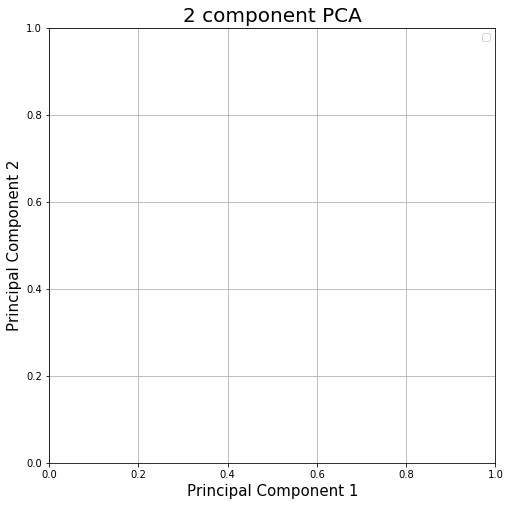

In [138]:
import matplotlib.pyplot as plt
import plotly.express as px
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(label_df['label'].unique())
colors =px.colors.qualitative.G10
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'pc1']
               , principal_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [139]:
import plotly.graph_objects as go
import seaborn as sns

In [140]:
import plotly.express as px
plt.figure(figsize=(25, 25))
fig = px.scatter(principal_df, x='pc1', y='pc2',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

<Figure size 1800x1800 with 0 Axes>

In [141]:
import plotly.express as px
fig = px.scatter_3d(principal_df, x='pc1', y='pc2', z='pc3',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(label_df['label'].unique())
print(len(targets))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '0.25', '0.5', '0.75', '0.9']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_df['label'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'tsne1']
               , tsne_df.loc[indicesToKeep, 'tsne2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
import plotly.express as px
plt.figure(figsize=(25, 25))
fig = px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

### Logistic Regression

In [8]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [10]:
train_valid_df.shape

(10222, 768)

In [19]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
clf.score(train_df, train_labels)

0.8004338394793926

In [21]:
clf.score(test_df, test_labels)

0.6632736156351792

### Keras DNN

In [53]:
train_lab = [id_dict[label] for label in train_labels]
valid_lab = [id_dict[label] for label in valid_labels]
test_lab = [id_dict[label] for label in test_labels]

In [79]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='softmax'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=200, batch_size=64)

Train on 9220 samples, validate on 1002 samples
Epoch 1/200
9220/9220 [==============================] - 1s 133us/step - loss: 2.2197 - acc: 0.2502 - val_loss: 2.1492 - val_acc: 0.2844
Epoch 2/200
9220/9220 [==============================] - 0s 41us/step - loss: 2.0988 - acc: 0.2734 - val_loss: 2.0491 - val_acc: 0.2844
Epoch 3/200
9220/9220 [==============================] - 0s 44us/step - loss: 2.0094 - acc: 0.2734 - val_loss: 1.9603 - val_acc: 0.3603
Epoch 4/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.9184 - acc: 0.4081 - val_loss: 1.8659 - val_acc: 0.3972
Epoch 5/200
9220/9220 [==============================] - 0s 39us/step - loss: 1.8253 - acc: 0.4132 - val_loss: 1.7772 - val_acc: 0.3992
Epoch 6/200
9220/9220 [==============================] - 0s 42us/step - loss: 1.7439 - acc: 0.4150 - val_loss: 1.7042 - val_acc: 0.3982
Epoch 7/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.6846 - acc: 0.4146 - val_loss: 1.6639 - val_acc: 0.3992

9220/9220 [==============================] - 1s 62us/step - loss: 1.0811 - acc: 0.6380 - val_loss: 1.2123 - val_acc: 0.5808
Epoch 61/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.0600 - acc: 0.6490 - val_loss: 1.1821 - val_acc: 0.6098
Epoch 62/200
9220/9220 [==============================] - 0s 40us/step - loss: 1.0438 - acc: 0.6534 - val_loss: 1.1980 - val_acc: 0.5928
Epoch 63/200
9220/9220 [==============================] - 0s 41us/step - loss: 1.0234 - acc: 0.6602 - val_loss: 1.1653 - val_acc: 0.6088
Epoch 64/200
9220/9220 [==============================] - 0s 42us/step - loss: 1.0054 - acc: 0.6662 - val_loss: 1.1456 - val_acc: 0.6078
Epoch 65/200
9220/9220 [==============================] - 0s 39us/step - loss: 0.9951 - acc: 0.6666 - val_loss: 1.1475 - val_acc: 0.6168
Epoch 66/200
9220/9220 [==============================] - 0s 46us/step - loss: 0.9879 - acc: 0.6683 - val_loss: 1.1222 - val_acc: 0.6228
Epoch 67/200
9220/9220 [==============================

Epoch 120/200
9220/9220 [==============================] - 1s 77us/step - loss: 0.8132 - acc: 0.7311 - val_loss: 1.1037 - val_acc: 0.6267
Epoch 121/200
9220/9220 [==============================] - 1s 59us/step - loss: 0.8074 - acc: 0.7324 - val_loss: 1.1231 - val_acc: 0.6287
Epoch 122/200
9220/9220 [==============================] - 1s 55us/step - loss: 0.8168 - acc: 0.7309 - val_loss: 1.0998 - val_acc: 0.6357
Epoch 123/200
9220/9220 [==============================] - 0s 42us/step - loss: 0.8032 - acc: 0.7347 - val_loss: 1.0962 - val_acc: 0.6357
Epoch 124/200
9220/9220 [==============================] - 0s 48us/step - loss: 0.8030 - acc: 0.7348 - val_loss: 1.1095 - val_acc: 0.6437
Epoch 125/200
9220/9220 [==============================] - 0s 49us/step - loss: 0.7976 - acc: 0.7337 - val_loss: 1.1149 - val_acc: 0.6387
Epoch 126/200
9220/9220 [==============================] - 1s 61us/step - loss: 0.8043 - acc: 0.7325 - val_loss: 1.1077 - val_acc: 0.6317
Epoch 127/200
9220/9220 [=========

9220/9220 [==============================] - 0s 40us/step - loss: 0.7297 - acc: 0.7552 - val_loss: 1.1849 - val_acc: 0.6108
Epoch 180/200
9220/9220 [==============================] - 0s 37us/step - loss: 0.7229 - acc: 0.7612 - val_loss: 1.1556 - val_acc: 0.6317
Epoch 181/200
9220/9220 [==============================] - 0s 39us/step - loss: 0.7189 - acc: 0.7627 - val_loss: 1.1828 - val_acc: 0.6228
Epoch 182/200
9220/9220 [==============================] - 0s 37us/step - loss: 0.7177 - acc: 0.7600 - val_loss: 1.1743 - val_acc: 0.6317
Epoch 183/200
9220/9220 [==============================] - 0s 37us/step - loss: 0.7317 - acc: 0.7576 - val_loss: 1.1932 - val_acc: 0.6178
Epoch 184/200
9220/9220 [==============================] - 0s 36us/step - loss: 0.7184 - acc: 0.7628 - val_loss: 1.1638 - val_acc: 0.6257
Epoch 185/200
9220/9220 [==============================] - 0s 39us/step - loss: 0.7190 - acc: 0.7654 - val_loss: 1.1729 - val_acc: 0.6307
Epoch 186/200
9220/9220 [=======================

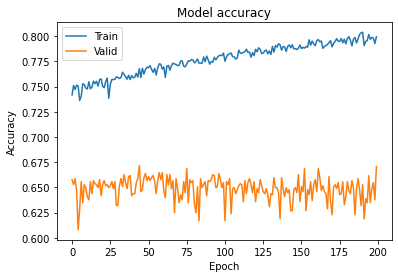

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [76]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 24us/step


[1.3570286637408726, 0.617671009577835]